In [4]:
conda install /kaggle/input/moviepy/*.tar.bz2


Retrieving notices: ...working... ERROR conda.notices.fetch:get_channel_notice_response(68): Request error <HTTPSConnectionPool(host='repo.anaconda.com', port=443): Max retries exceeded with url: /pkgs/main/notices.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x78f00cd7d030>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))> for channel: defaults url: https://repo.anaconda.com/pkgs/main/notices.json
ERROR conda.notices.fetch:get_channel_notice_response(68): Request error <HTTPSConnectionPool(host='conda.anaconda.org', port=443): Max retries exceeded with url: /rapidsai/notices.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x78f00cd7ce50>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))> for channel: rapidsai url: https://conda.anaconda.org/rapidsai/notices.json
ERROR conda.notices.fetch:get_channel_notice_response(68): Request error <

In [10]:
import os
import cv2
#import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [11]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


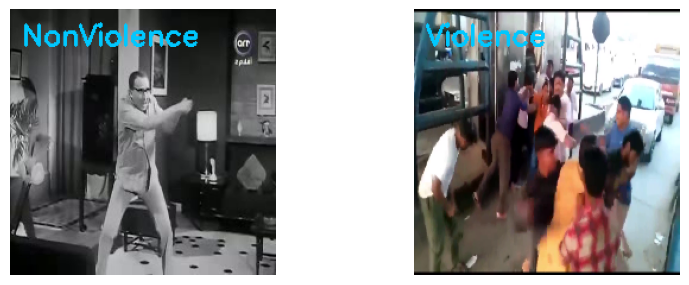

In [12]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset')


# Iterating through all the generated random values.
for counter, random_index in enumerate(range(len(all_classes_names)), 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/{selected_class_Name}/{selected_video_file_name}')
    video_reader.set(1, 25)

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
  
    bgr_frame = cv2.resize(bgr_frame ,(224,224))
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [13]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["NonViolence", "Violence"]


In [14]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [15]:
def create_dataset():
    

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [16]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()


Extracting Data of Class: NonViolence


[h264 @ 0x597766b70f40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x597766b70f40] error while decoding MB 98 31
[h264 @ 0x597766b70f40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x597766b70f40] error while decoding MB 98 31
[h264 @ 0x597766b70f40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x597766b70f40] error while decoding MB 98 31
[h264 @ 0x597766b70f40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x597766b70f40] error while decoding MB 98 31
[h264 @ 0x597766b70f40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x597766b70f40] error while decoding MB 98 31
[h264 @ 0x597766b70f40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x597766b70f40] error while decoding MB 98 31
[h264 @ 0x597766b70f40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x597766b70f40] error while decoding MB 98 31


Extracting Data of Class: Violence


In [17]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)


In [18]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
features = None
labels = None

In [19]:
def create_LRCN_model():
    

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
#     model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))


    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [38]:
model = create_LRCN_model()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeD  (None, 30, 64, 64, 32)    896       
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 30, 16, 16, 32)    0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 30, 16, 16, 64)    18496     
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 30, 4, 4, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, 30, 4, 4, 128)    

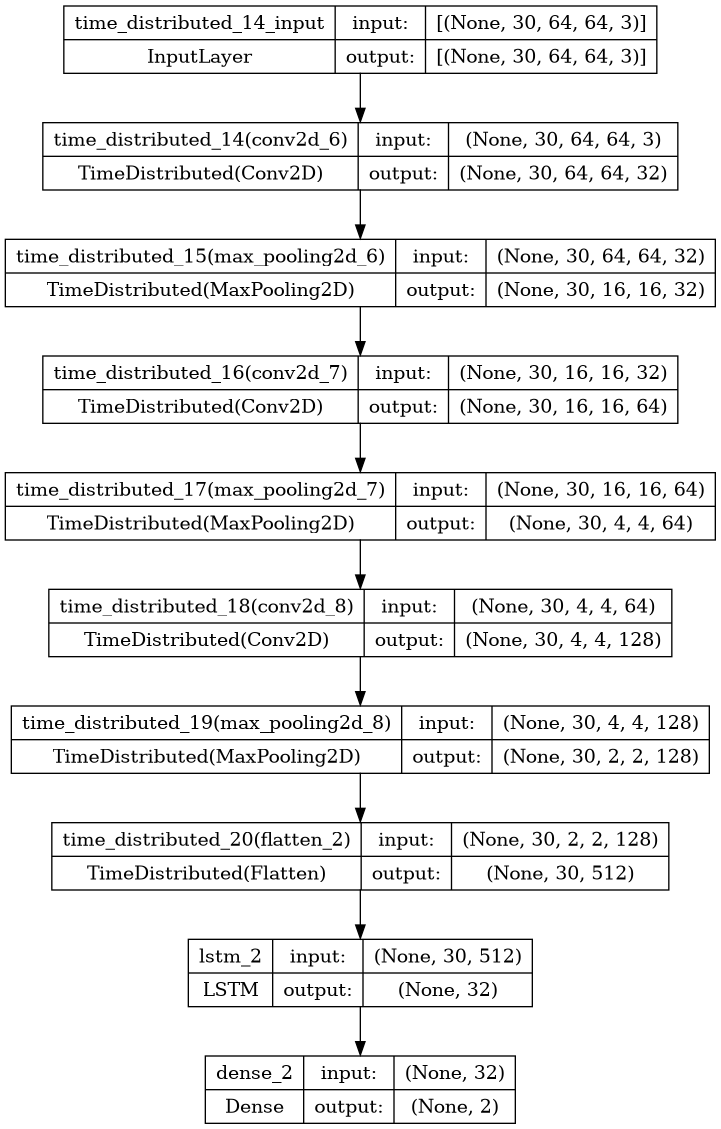

In [39]:
plot_model(model, to_file = 'Suspicious_Human_Activity_LRCN_Model.png', show_shapes = True, show_layer_names = True)


In [40]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])


Epoch 1/70
281/281 [==============================] - 9s 20ms/step - loss: 0.6785 - accuracy: 0.5646 - val_loss: 0.6330 - val_accuracy: 0.6320
Epoch 2/70
281/281 [==============================] - 4s 15ms/step - loss: 0.5902 - accuracy: 0.6857 - val_loss: 0.5386 - val_accuracy: 0.7707
Epoch 3/70
281/281 [==============================] - 4s 15ms/step - loss: 0.4969 - accuracy: 0.7542 - val_loss: 0.4754 - val_accuracy: 0.7680
Epoch 4/70
281/281 [==============================] - 4s 16ms/step - loss: 0.4097 - accuracy: 0.8166 - val_loss: 0.4864 - val_accuracy: 0.7333
Epoch 5/70
281/281 [==============================] - 4s 15ms/step - loss: 0.3386 - accuracy: 0.8549 - val_loss: 0.3697 - val_accuracy: 0.8293
Epoch 6/70
281/281 [==============================] - 4s 16ms/step - loss: 0.2537 - accuracy: 0.8940 - val_loss: 0.3541 - val_accuracy: 0.8640
Epoch 7/70
281/281 [==============================] - 4s 15ms/step - loss: 0.2342 - accuracy: 0.9056 - val_loss: 0.3872 - val_accuracy: 0.8267

In [41]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

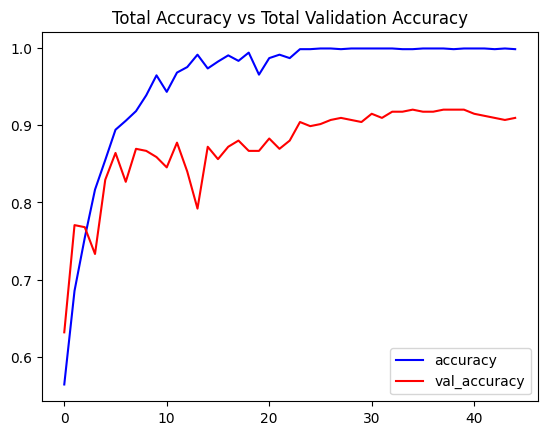

In [42]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [43]:
# Calculate Accuracy On Test Dataset
acc = 0
for i in range(len(features_test)):
  predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0])
  actual_label = np.argmax(labels_test[i])
  if predicted_label == actual_label:
      acc += 1
acc = (acc * 100)/len(labels_test)
print("Accuracy =",acc)

1/1 [==============================] - 0s 22ms/step
Accuracy = 89.8


In [44]:
model.save("Security.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
model.save("Security.keras")

1/1 [==============================] - 0s 21ms/step


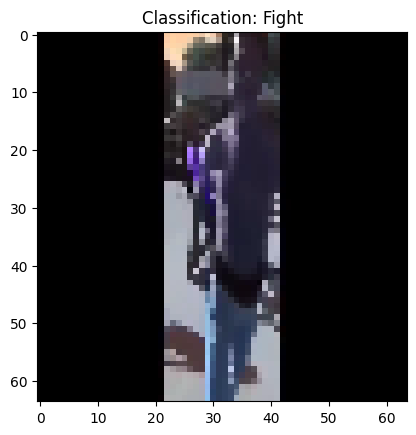

In [46]:
from tensorflow.keras.models import load_model

# Load the trained model
# model = load_model("/kaggle/input/model/tensorflow2/default/1")

# Function to extract frames from a new AVI video
def extract_frames_from_new_avi_video(video_path):
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    
    while True:
        success, frame = video_reader.read()
        if not success:
            break

        # Resize and normalize the frame
        resized_frame = cv2.resize(frame, (64, 64)) / 255.0
        frames.append(resized_frame)

    video_reader.release()
    return frames

# Function to predict the class of an AVI video and display the image
def predict_avi_video_class(video_path):
    frames = extract_frames_from_new_avi_video(video_path)
    if len(frames) < 30:
        print("Not enough frames for prediction.")
        return
    
    frames_sequence = np.array(frames[:30]) # Select the first 30 frames for prediction
    frames_sequence = np.expand_dims(frames_sequence, axis=0) # Add batch dimension
    
    # Make predictions using the model
    predicted_label = np.argmax(model.predict(frames_sequence)[0])
    
    if predicted_label == 0:
        classification = "No Fight"
    else:
        classification = "Fight"
    
    # Display the last frame of the video along with the classification result
    last_frame = frames[-1]
    
    # Ensure the image is in the correct format (e.g., 8-bit unsigned integer)
    last_frame = (last_frame * 255).astype(np.uint8)
    
    plt.imshow(last_frame)
    plt.title(f"Classification: {classification}")
    plt.show()

# Test the model on a new AVI video
new_avi_video_path = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_102.mp4"
predict_avi_video_class(new_avi_video_path)

In [ ]:
%%writefile app.py


## Import Library

In [1]:
%matplotlib inline
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow import keras
# from tensorflow.keras import keras
from tensorflow.keras import layers
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.applications import MobileNetV3Small

2024-08-10 14:53:04.261184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 14:53:04.261346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 14:53:04.448126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Hyperparameter

In [2]:
# DATA
DATASET_NAME = "weapon"
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (180, 96, 96, 3)
INPUT_SHAPE_2D = (96, 96, 3)
MAX_FRAMES = 180
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4

# TRAINING
EPOCHS = 20
DATA_NUM = 250
# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 12

# MOBILENETV
MOBILENET_NUM_LAYER = 40

## Dataset Setting

In [3]:
def load_video(path, max_frames = MAX_FRAMES, resize = (96, 96), dtype = np.float16):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret or frame_count >= max_frames:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, resize)
            frames.append(frame.astype(dtype))
            frame_count += 1
    finally:
        cap.release()

    while len(frames) < max_frames:
        frames.append(frames[-1].astype(dtype))

    return np.array(frames)

In [4]:
def prepare_dataset(folder_path):
    class_names = ["NonViolence", "Violence"]
    x, y = [], []
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        video_cnt = 0
        for video_file in os.listdir(class_folder):
            if video_cnt > DATA_NUM:
                break
            video_path = os.path.join(class_folder, video_file)
            frames = load_video(video_path)
            x.append(frames)
            y.append(class_index)
            video_cnt += 1

    return np.array(x), keras.utils.to_categorical(y, num_classes=len(class_names))

dataset_path = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset"

x, y = prepare_dataset(dataset_path)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.1, random_state = 123)

## MobileNetV3 Model

In [5]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class MobileNetV3FeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, num_frames, **kwargs):
        super().__init__(**kwargs)
        self.num_frames = num_frames

        self.mobilenetv3 = tf.keras.applications.MobileNetV3Small(input_shape=INPUT_SHAPE_2D, include_top=False, weights='imagenet')
        self.reduced_mobilenetv3_model = tf.keras.Model(inputs=self.mobilenetv3.input, outputs=self.mobilenetv3.layers[MOBILENET_NUM_LAYER].output)

        self.pooling = tf.keras.layers.GlobalAveragePooling2D()

        self.dense = tf.keras.layers.Dense(PROJECTION_DIM)

    def call(self, inputs):
        frames = tf.split(inputs, num_or_size_splits=self.num_frames, axis=1)
        frame_features = [self.dense(self.pooling(self.reduced_mobilenetv3_model(tf.squeeze(frame, axis=1)))) for frame in frames]

        features = tf.stack(frame_features, axis=1)
        return features

## Positional Embedding by ViT

In [6]:
@tf.keras.utils.register_keras_serializable()
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim = num_tokens, output_dim = self.embed_dim
        )
        self.positions = tf.range(start = 0, limit = num_tokens, delta = 1)

    def call(self, encoded_tokens):
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

## ViT Model

In [7]:
def create_vivit_model(
    feature_extractor,
    positional_encoder,
    input_shape = INPUT_SHAPE,
    transformer_layers = NUM_LAYERS,
    num_heads = NUM_HEADS,
    embed_dim = PROJECTION_DIM,
    layer_norm_eps = LAYER_NORM_EPS,
    num_classes = NUM_CLASSES
):
    
    inputs = layers.Input(shape = input_shape)

    
    features = feature_extractor(inputs)

    
    encoded_patches = positional_encoder(features)

    
    for _ in range(transformer_layers):
        
        x1 = layers.LayerNormalization(epsilon = LAYER_NORM_EPS)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = embed_dim // num_heads, dropout = 0.1
        )(x1, x1)

        
        x2 = layers.Add()([attention_output, encoded_patches])

        
        x3 = layers.LayerNormalization(epsilon = LAYER_NORM_EPS)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units = embed_dim * 4, activation = tf.nn.gelu),
                layers.Dense(units = embed_dim, activation = tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

        
    representation = layers.LayerNormalization(epsilon = layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)
    representation = layers.Dropout(0.1)(representation)

    
    outputs = layers.Dense(units = num_classes, activation = "softmax")(representation)

    
    model = keras.Model(inputs = inputs, outputs = outputs)
    return model

In [8]:
model = create_vivit_model(
    feature_extractor = MobileNetV3FeatureExtractor(num_frames=MAX_FRAMES),
    positional_encoder = PositionalEncoder(embed_dim = PROJECTION_DIM),
    )

# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


## Model Learning

In [9]:

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor = "loss", patience = 10, restore_best_weights= True)


reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor = "loss", factor = 0.6, patience = 5,
    min_lr = 0.00005, verbose = 1)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

hist = model.fit(train_dataset, epochs = EPOCHS, callbacks = [early_stopping_callback, reduce_lr_callback])
loss = model.evaluate(train_dataset)

print(f"Train Loss: {loss}")

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 

57/57 ━━━━━━━━━━━━━━━━━━━━ 971s 4s/step - loss: 0.9913 - precision: 0.5177 - recall: 0.5177 - learning_rate: 0.0010
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - loss: 0.7232 - precision: 0.5598 - recall: 0.5598 - learning_rate: 0.0010
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - loss: 0.6765 - precision: 0.6319 - recall: 0.6319 - learning_rate: 0.0010
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - loss: 0.5981 - precision: 0.6770 - recall: 0.6770 - learning_rate: 0.0010
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - loss: 0.5170 - precision: 0.7721 - recall: 0.7721 - learning_rate: 0.0010
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - loss: 0.4244 - precision: 0.8368 - recall: 0.8368 - learning_rate: 0.0010
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - loss: 0.4157 - precision: 0.8221 - recall: 0.8221 - learning_rate: 0.0010
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - loss: 0.3637 - precision: 0.8580 - recall: 0.8580 - learning_rate: 0.

## Model Test

In [11]:
# 훈련과 평가 데이터셋 나누기
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

# model.fit(test_dataset, epochs = EPOCHS)
ts_loss, ts_precision, ts_recall = model.evaluate(test_dataset)
print(f"Test Loss: {ts_loss}")
print(f"Test Precision: {ts_precision}")
print(f"Test Recall: {ts_recall}")

f1_score = 2 * (ts_precision * ts_recall) / (ts_precision + ts_recall)
print(f"F1 Score: {f1_score}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.4724 - precision: 0.8492 - recall: 0.8492
Test Loss: 0.6443987488746643
Test Precision: 0.8039215803146362
Test Recall: 0.8039215803146362
F1 Score: 0.8039215803146362


In [12]:
model.save('VivitModel.keras')

In [13]:
model2 = keras.models.load_model('/kaggle/working/VivitModel.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:359: UserWarning: `build()` was called on layer 'mobile_net_v3_feature_extractor', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [14]:
!pip show tensorflow | grep Version

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Version: 2.15.0


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 22.8 MB/s eta 0:00:0000:01


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.yaml") 

results = model.train(data="/kaggle/input/weapons/data.yaml",epochs=125)

Ultralytics YOLOv8.2.75 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/input/weapons/data.yaml, epochs=125, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

100%|██████████| 755k/755k [00:00<00:00, 27.4MB/s]
2024-08-10 16:43:23,602	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-10 16:43:24,427	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/input/weapons/train/labels... 2551 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2551/2551 [00:07<00:00, 343.08it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/weapons/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/weapons/valid/labels... 417 images, 0 backgrounds, 0 corrupt: 100%|██████████| 417/417 [00:01<00:00, 318.17it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/weapons/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train6
Starting training for 125 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/125      2.38G      3.038      3.438      3.888         13        640: 100%|██████████| 160/160 [00:32<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]


                   all        417        461    0.00273       0.74     0.0541     0.0167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/125      2.34G      2.354      3.035      2.969         11        640: 100%|██████████| 160/160 [00:29<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.35it/s]

                   all        417        461     0.0786      0.358     0.0489     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/125      2.33G      2.009      2.609      2.541         32        640: 100%|██████████| 160/160 [00:29<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.32it/s]

                   all        417        461      0.442      0.347      0.267     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/125      2.33G      1.854      2.419      2.353         14        640: 100%|██████████| 160/160 [00:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.02it/s]

                   all        417        461      0.479      0.364      0.265      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/125      2.33G      1.744      2.294       2.24         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.51it/s]

                   all        417        461      0.416      0.377      0.334      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/125      2.33G      1.698      2.214      2.148         23        640: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.61it/s]

                   all        417        461      0.364      0.356      0.308      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/125      2.33G      1.562      2.056      2.029         11        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.83it/s]

                   all        417        461       0.49       0.43      0.416      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/125      2.32G      1.552      2.005      2.002         12        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]

                   all        417        461      0.564      0.458      0.483      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/125      2.33G      1.474      1.923       1.94         12        640: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.55it/s]

                   all        417        461      0.652      0.453      0.515      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/125      2.32G      1.429      1.837      1.897         24        640: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.91it/s]

                   all        417        461      0.547      0.423      0.443      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/125      2.32G      1.426       1.83      1.877         16        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.75it/s]

                   all        417        461      0.592       0.46      0.484      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/125      2.32G      1.393      1.794      1.852         22        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        417        461      0.667      0.497      0.565      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/125      2.33G       1.37       1.76      1.831         20        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        417        461      0.661      0.518      0.581      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/125      2.33G      1.323      1.691      1.794         12        640: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]

                   all        417        461      0.655      0.456      0.521      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/125      2.32G      1.312      1.686      1.787          9        640: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.83it/s]

                   all        417        461      0.763      0.473      0.584      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/125      2.33G      1.309      1.676      1.785         11        640: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.77it/s]

                   all        417        461      0.697      0.527      0.606      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/125      2.32G      1.267      1.621      1.741         23        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.74it/s]

                   all        417        461       0.73      0.551      0.611      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/125      2.32G      1.256      1.601      1.731         22        640: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.74it/s]

                   all        417        461      0.715      0.534      0.625      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/125      2.33G      1.236      1.563      1.718         17        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.74it/s]

                   all        417        461      0.768      0.452      0.594      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/125      2.33G      1.204      1.513      1.676         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.76it/s]

                   all        417        461      0.724      0.551      0.643      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/125      2.33G      1.208      1.499      1.676         18        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.84it/s]

                   all        417        461      0.712      0.531      0.619      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/125      2.32G      1.195      1.512      1.666         16        640: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

                   all        417        461      0.708      0.542      0.633      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/125      2.32G      1.172      1.455      1.659         18        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.91it/s]

                   all        417        461      0.722       0.57      0.639      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/125      2.32G      1.179      1.479      1.666         18        640: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.84it/s]

                   all        417        461      0.693      0.577      0.651       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/125      2.33G      1.147      1.436      1.635         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.75it/s]

                   all        417        461      0.814      0.553      0.681      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/125      2.32G      1.149      1.432       1.63         13        640: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        417        461      0.752      0.521      0.629      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/125      2.32G      1.153       1.42      1.631         17        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.83it/s]

                   all        417        461      0.788      0.564      0.677      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/125      2.32G      1.126      1.389      1.613         17        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

                   all        417        461      0.771      0.573      0.678      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/125      2.32G      1.121      1.374      1.603         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.77it/s]

                   all        417        461      0.798      0.618      0.701      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/125      2.33G      1.133      1.367      1.611         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.76it/s]

                   all        417        461      0.779      0.577      0.692      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/125      2.32G      1.092      1.323      1.577         17        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.97it/s]

                   all        417        461      0.767      0.607        0.7      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/125      2.32G      1.088      1.322       1.57         21        640: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.80it/s]

                   all        417        461      0.776      0.586      0.697      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/125      2.32G      1.087      1.311       1.57         18        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

                   all        417        461      0.789      0.588      0.692      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/125      2.32G      1.096      1.307      1.581         23        640: 100%|██████████| 160/160 [00:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]

                   all        417        461      0.784      0.568      0.672       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/125      2.32G      1.061      1.274      1.544         23        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.80it/s]

                   all        417        461      0.809      0.588      0.707      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/125      2.32G      1.069      1.293      1.547         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.86it/s]

                   all        417        461      0.807      0.577      0.687      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/125      2.32G      1.072      1.285      1.555          9        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.91it/s]

                   all        417        461      0.771       0.59      0.703      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/125      2.32G      1.063      1.246      1.548         18        640: 100%|██████████| 160/160 [00:28<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.86it/s]

                   all        417        461      0.841       0.59      0.714      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/125      2.32G      1.056      1.226      1.538         13        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.73it/s]

                   all        417        461      0.808      0.625      0.726      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/125      2.33G      1.051      1.205      1.531         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.91it/s]

                   all        417        461      0.759      0.651      0.731      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/125      2.32G      1.027      1.198      1.517         21        640: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.94it/s]

                   all        417        461      0.748      0.646      0.718      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/125      2.32G       1.03      1.209      1.511         26        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.76it/s]

                   all        417        461      0.859      0.622      0.736      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/125      2.32G      1.049       1.21      1.529         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.77it/s]

                   all        417        461      0.734      0.616      0.722      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/125      2.32G      1.018      1.182      1.503         16        640: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.82it/s]

                   all        417        461      0.857      0.584      0.729      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/125      2.32G      1.017      1.177      1.511         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.75it/s]

                   all        417        461      0.854      0.609      0.731      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/125      2.33G      1.012      1.168      1.503         15        640: 100%|██████████| 160/160 [00:28<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.89it/s]

                   all        417        461      0.821      0.627      0.741      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/125      2.33G      1.004      1.163      1.487         14        640: 100%|██████████| 160/160 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.81it/s]

                   all        417        461      0.812      0.636      0.736      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/125      2.33G       1.01      1.168      1.495         20        640: 100%|██████████| 160/160 [00:28<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.87it/s]

                   all        417        461      0.825      0.615      0.747      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/125      2.32G      1.003      1.133      1.487         23        640: 100%|██████████| 160/160 [00:28<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.89it/s]

                   all        417        461      0.806      0.644      0.737      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/125      2.32G      1.002      1.144      1.487         34        640: 100%|██████████| 160/160 [00:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.89it/s]

                   all        417        461      0.799      0.656       0.74       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/125      2.32G     0.9766      1.115      1.474         20        640: 100%|██████████| 160/160 [00:28<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.87it/s]

                   all        417        461      0.872      0.616      0.747      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/125      2.33G     0.9645      1.101      1.459         18        640: 100%|██████████| 160/160 [00:28<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]

                   all        417        461      0.892       0.61      0.764      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/125      2.32G     0.9786      1.129      1.471         22        640: 100%|██████████| 160/160 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.84it/s]

                   all        417        461      0.761      0.655      0.744      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/125      2.32G     0.9801      1.104      1.466         25        640: 100%|██████████| 160/160 [00:28<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.87it/s]

                   all        417        461      0.909      0.599      0.747      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/125      2.32G     0.9718      1.114      1.459         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.91it/s]

                   all        417        461      0.833      0.646      0.757      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/125      2.32G      0.959      1.076      1.449         21        640: 100%|██████████| 160/160 [00:28<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.99it/s]

                   all        417        461      0.826       0.67      0.769      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/125      2.32G     0.9668       1.09      1.455         21        640: 100%|██████████| 160/160 [00:28<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.73it/s]

                   all        417        461      0.832      0.646      0.766      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/125      2.32G     0.9552      1.056      1.451         16        640: 100%|██████████| 160/160 [00:28<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.83it/s]

                   all        417        461      0.867      0.651      0.776      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/125      2.32G     0.9495      1.068      1.451         13        640: 100%|██████████| 160/160 [00:28<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.93it/s]

                   all        417        461      0.865      0.651      0.766      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/125      2.32G     0.9507      1.043      1.445         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.07it/s]

                   all        417        461      0.878      0.624      0.758       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/125      2.32G     0.9546      1.062      1.441         17        640: 100%|██████████| 160/160 [00:28<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.93it/s]

                   all        417        461      0.833      0.673      0.766      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/125      2.32G     0.9385      1.049      1.438         18        640: 100%|██████████| 160/160 [00:28<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]

                   all        417        461      0.848      0.668      0.772      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/125      2.32G     0.9487      1.044      1.437         20        640: 100%|██████████| 160/160 [00:28<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.05it/s]


                   all        417        461      0.799      0.701      0.777      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/125      2.33G     0.9298      1.036      1.435         18        640: 100%|██████████| 160/160 [00:28<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.95it/s]

                   all        417        461       0.89      0.649      0.781      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/125      2.32G     0.9143      1.012      1.416         17        640: 100%|██████████| 160/160 [00:28<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.89it/s]

                   all        417        461      0.905       0.67       0.79      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/125      2.33G     0.9179      1.002      1.414         16        640: 100%|██████████| 160/160 [00:28<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.06it/s]


                   all        417        461      0.876      0.675      0.782      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/125      2.32G      0.922      1.001      1.415         19        640: 100%|██████████| 160/160 [00:28<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.81it/s]

                   all        417        461      0.892      0.666      0.779      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/125      2.32G     0.8966     0.9749      1.396         16        640: 100%|██████████| 160/160 [00:28<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.79it/s]

                   all        417        461      0.879      0.662      0.777      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/125      2.32G     0.9254     0.9932      1.424         17        640: 100%|██████████| 160/160 [00:28<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]

                   all        417        461      0.793      0.692      0.772      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/125      2.32G     0.9001     0.9884      1.397         18        640: 100%|██████████| 160/160 [00:28<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.03it/s]

                   all        417        461      0.864      0.651      0.778      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/125      2.32G     0.9024     0.9676      1.397         12        640: 100%|██████████| 160/160 [00:28<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.86it/s]

                   all        417        461      0.865      0.675      0.788      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/125      2.32G     0.9099     0.9923      1.406         20        640: 100%|██████████| 160/160 [00:28<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.77it/s]

                   all        417        461      0.838      0.705      0.779       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/125      2.32G     0.9438     0.9931      1.431         39        640:  21%|██        | 33/160 [00:06<00:23,  5.47it/s]

In [ ]:
import torch

model_path = "/kaggle/working/best.pt"
torch.save(model.state_dict(), model_path)

print(f"Model state dict saved to {model_path}")

In [ ]:
# from ultralytics import YOLO

# data_path = "/kaggle/input/weapons/data.yaml"  # Path to your dataset configuration file
# epochs = 40 

# results = model.train(data=data_path, epochs=epochs,resume=True)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

results = model('/kaggle/input/weapons/train/images/armas--1027-_jpg.rf.ade190f152bb7c12ac2b056d65d3f671.jpg')

for r in results:
    print(dir(r))
#     probs = result.verbose # Convert to numpy array if needed
#     print("Probabilities (possible scores):", probs)
    im_array = r.plot()
    im = Image.fromarray(im_array)
    plt.imshow(im)
    plt.axis('off') 
    plt.show()

In [ ]:
import cv2

detected = False

# Load the video
video_path = "/kaggle/input/gunvideo/GunVideo.mp4"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

output_path = '/kaggle/working/output_video.mp4'

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
print("*****************************",fps)

out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, conf=0.5)
    if results[0].boxes:
        detected = True;

    annotated_frame = results[0].plot()     
    out.write(annotated_frame)

# Release the video objects
cap.release()
out.release()

print("**************************************************")

In [ ]:
if(detected):
    print("Yes Detected")
else:
    print("No Gun Detected")

In [ ]:
import torch

path = '/kaggle/input/best-model/best (1).pt'
model = YOLO()  # Replace with the correct model class/architecture
model.load_state_dict(torch.load(path), strict=False)

model.eval()

In [ ]:
from ultralytics import YOLO

model = YOLO('/kaggle/working/runs/detect/train4/weights/best.pt')

results = model('/kaggle/input/gunvideo/GunVideo.mp4')  # Replace with the actual path to your image or video

results.show()

In [ ]:
# !pip install ultralytics

import ultralytics
import cv2

def weapon_detection(video_path):
    model = YOLO('/kaggle/working/runs/detect/train4/weights/best.pt')
    
#     video_path = "/kaggle/input/gunvideo/GunVideo.mp4"  # Replace with your video file path
    cap = cv2.VideoCapture(video_path)
    
    output_path = '/kaggle/working/output_video_again.mp4'

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print("*****************************",fps)
    detected = False
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    # Process each frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, conf=0.3)
        if results[0].boxes:
            detected = True;

        annotated_frame = results[0].plot()     
        out.write(annotated_frame)

    # Release the video objects
    cap.release()
    out.release()
    
    if(detected):
        return "Yes";
    else:
        return "No";

In [ ]:
print(weapon_detection('/kaggle/input/gunvideo2/1009866086-preview.mp4'))

In [ ]:
# from ultralytics import YOLO

# model = YOLO('/kaggle/working/runs/detect/train4/weights/best.pt')

# model.train(data='/kaggle/input/weapons/data.yaml', epochs=125, resume=True)

# Final Streamlit Implementation

In [ ]:
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications import MobileNetV3Small
from ultralytics import YOLO

#yolo part
# !pip install ultralytics

import ultralytics
import cv2

def weapon_detection(video_path):
    model = YOLO('best.pt')
    
    cap = cv2.VideoCapture(video_path)
    
    output_path = '/kaggle/working/output_video_again.mp4'

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print("*",fps)
    detected = False
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    # Process each frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, conf=0.3)
        if results[0].boxes:
            detected = True;

        annotated_frame = results[0].plot()     
        out.write(annotated_frame)

    # Release the video objects
    cap.release()
    out.release()
    
    if(detected):
        return 1
    else:
        return 0
        
#vivit part

#hyperparameters
INPUT_SHAPE = (180, 96, 96, 3)
INPUT_SHAPE_2D = (96, 96, 3)
MAX_FRAMES = 180
NUM_CLASSES = 2
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2
# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 12
# MOBILENETV
MOBILENET_NUM_LAYER = 40
def load_video(path, max_frames = MAX_FRAMES, resize = (96, 96), dtype = np.float16):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret or frame_count >= max_frames:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, resize)
            frames.append(frame.astype(dtype))
            frame_count += 1
    finally:
        cap.release()

    while len(frames) < max_frames:
        frames.append(frames[-1].astype(dtype))

    return np.array(frames)
@tf.keras.utils.register_keras_serializable()
class MobileNetV3FeatureExtractor(tf.keras.layers.Layer):
    def _init_(self, num_frames, **kwargs):
        super()._init_(**kwargs)
        self.num_frames = num_frames

        self.mobilenetv3 = tf.keras.applications.MobileNetV3Small(input_shape=INPUT_SHAPE_2D, include_top=False, weights='imagenet')
        self.reduced_mobilenetv3_model = tf.keras.Model(inputs=self.mobilenetv3.input, outputs=self.mobilenetv3.layers[MOBILENET_NUM_LAYER].output)

        self.pooling = tf.keras.layers.GlobalAveragePooling2D()

        self.dense = tf.keras.layers.Dense(PROJECTION_DIM)

    def call(self, inputs):
        frames = tf.split(inputs, num_or_size_splits=self.num_frames, axis=1)
        frame_features = [self.dense(self.pooling(self.reduced_mobilenetv3_model(tf.squeeze(frame, axis=1)))) for frame in frames]

        features = tf.stack(frame_features, axis=1)
        return features
@tf.keras.utils.register_keras_serializable()
class PositionalEncoder(layers.Layer):
    def _init_(self, embed_dim, **kwargs):
        super()._init_(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim = num_tokens, output_dim = self.embed_dim
        )
        self.positions = tf.range(start = 0, limit = num_tokens, delta = 1)

    def call(self, encoded_tokens):
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens
model_vivit = keras.models.load_model('VivitModellast.keras')

# LRCN part
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/kaggle/input/security.keras")

# Function to extract frames from a new AVI video
def extract_frames_from_new_avi_video(video_path):
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    
    while True:
        success, frame = video_reader.read()
        if not success:
            break

        # Resize and normalize the frame
        resized_frame = cv2.resize(frame, (64, 64)) / 255.0
        frames.append(resized_frame)

    video_reader.release()
    return frames

# Function to predict the class of an AVI video and display the image
def predict_avi_video_class(video_path):
    frames = extract_frames_from_new_avi_video(video_path)
    if len(frames) < 30:
        print("Not enough frames for prediction.")
        return
    
    frames_sequence = np.array(frames[:30]) # Select the first 30 frames for prediction
    frames_sequence = np.expand_dims(frames_sequence, axis=0) # Add batch dimension
    
    # Make predictions using the model
    predicted_label = np.argmax(model.predict(frames_sequence)[0])
    
    if predicted_label == 0:
        return 0
    else:
        return 1
        
# Replace with your actual video processing and prediction functions
def predict_with_lrcn(video_path):
    # pass
    return predict_avi_video_class(video_path)

def predict_with_vivit(video_path):
    video = load_video(video_path)
    video = np.expand_dims(video, axis=0)
    video = tf.convert_to_tensor(video, dtype=tf.float32)
    pred = model_vivit.predict(video)
    if(pred[0][0] > pred[0][1]):
        return 0
    else:
        return 1
    

def main():
    st.title("Violence Detection")

    uploaded_file = st.file_uploader("Upload a video", type=["mp4", "avi", "mov"])

    if uploaded_file is not None:
        video_bytes = uploaded_file.read()
        video_path = "temp_video.mp4"
        with open(video_path, "wb") as f:
            f.write(video_bytes)

        st.video(video_path)

        model_choice = st.radio("Choose a model:", ("LRCN", "ViViT"))

        if st.button("Submit"):
            if model_choice == "LRCN":
                prediction = predict_with_vivit(video_path)
            else:
                prediction = predict_with_vivit(video_path)
            
            #yolo
            if(weapon_detection(video_path)):
                st.error("Video contains person with weapon")
            else:
                st.success("Video does not contain person with weapon")

            if prediction == 1:
                st.error("Video contains violence")
            else:
                st.success("Video does not contain violence")

if _name_ == "_main_":
    main()